In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
california = fetch_california_housing()
data = pd.DataFrame(california.data, columns=california.feature_names)
data['Price'] = california.target


In [4]:
data = data.sort_values('Price').reset_index(drop=True)
prices = data['Price'].values.reshape(-1, 1)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

In [6]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data[i:(i+seq_length), 0])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

In [7]:
seq_length = 10  # Number of previous time steps to use for prediction
X, y = create_sequences(scaled_prices, seq_length)


In [8]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
model = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    SimpleRNN(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

C:\Users\Admin\Documents\TY sem-2\CSAI-76\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0218 - val_loss: 0.0010
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0012 - val_loss: 1.5267e-04
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 7.2613e-04 - val_loss: 1.7543e-04
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.9648e-04 - val_loss: 5.0508e-04
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.5854e-04 - val_loss: 2.1039e-04
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2.6691e-04 - val_loss: 5.8534e-05
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.0019e-04 - val_loss: 2.6661e-05
Epoch 8/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.6032e-04 - val_loss: 6.7928e-06
Epoch 9/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.3698e-04 - val_loss: 1.1620e-04
Epoch 10/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.1861e-04 - val_loss: 6.7838e-05
Epoch 11/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.0658e-0

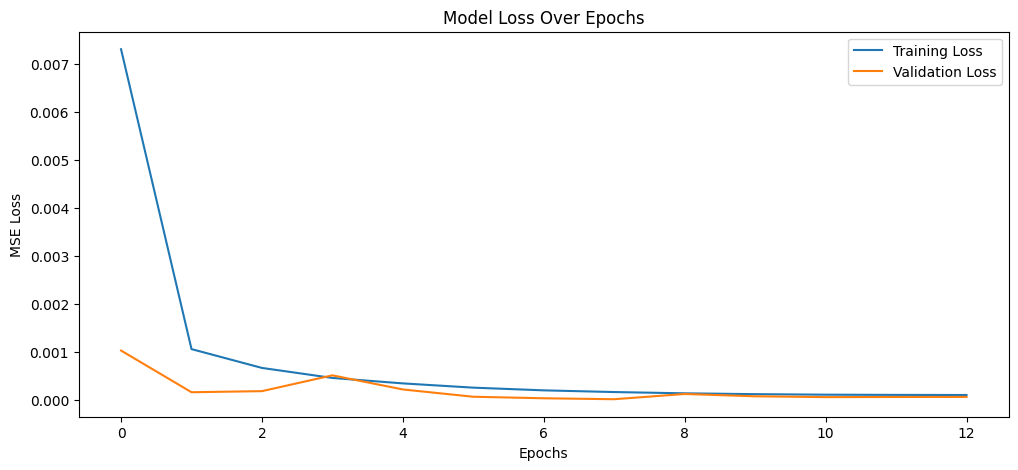

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [12]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [13]:
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
train_mae = mean_absolute_error(y_train_actual, train_predict)
test_mae = mean_absolute_error(y_test_actual, test_predict)

print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")


Train RMSE: 0.0192, Test RMSE: 0.2983
Train MAE: 0.0182, Test MAE: 0.2357


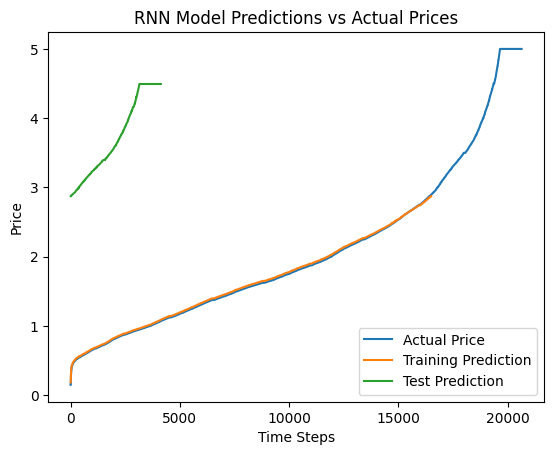

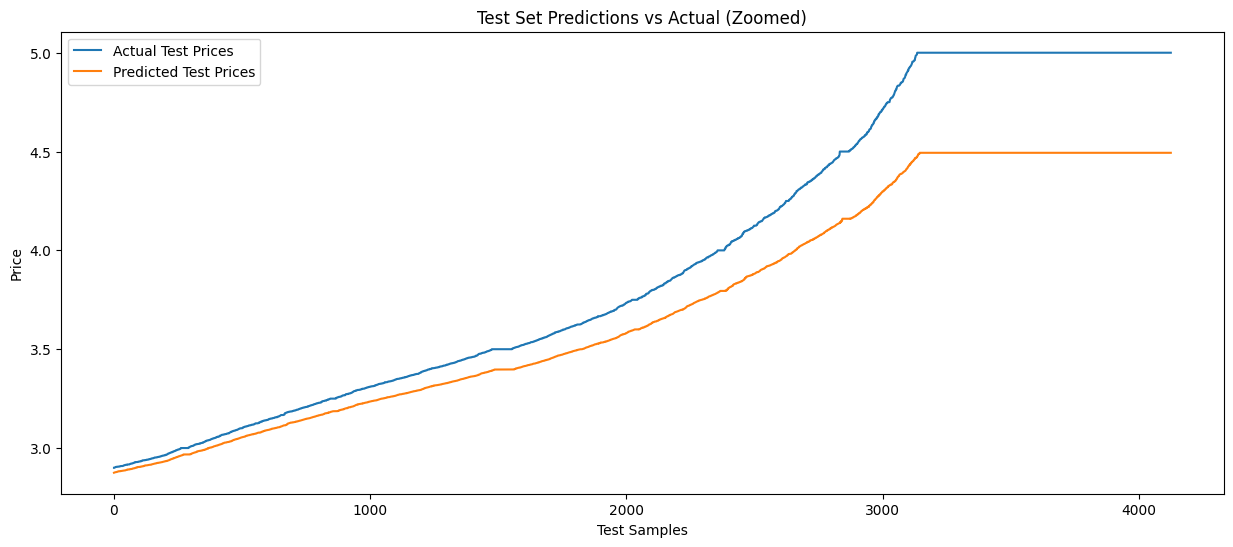

In [14]:
plt.plot(scaler.inverse_transform(scaled_prices), label='Actual Price')
plt.plot(train_predict, label='Training Prediction')
plt.plot(test_predict, label='Test Prediction')
plt.title('RNN Model Predictions vs Actual Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()


plt.figure(figsize=(15, 6))
plt.plot(y_test_actual, label='Actual Test Prices')
plt.plot(test_predict, label='Predicted Test Prices')
plt.title('Test Set Predictions vs Actual (Zoomed)')
plt.xlabel('Test Samples')
plt.ylabel('Price')
plt.legend()
plt.show()